## Correct path prediction :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import kerastuner as kt
from tensorflow .data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
tf.test.is_gpu_available()

In [ ]:
picktime = pd.read_csv('../dataPreprocessing/data/gps_clean.csv', low_memory=False)
picktime.info()

In [ ]:
target_encoder = dict( (target,code) for code, target in enumerate(picktime.line_id.unique()) )
target_decoder = dict( (code, target) for target, code in target_encoder.items() ) 

In [ ]:
nb_targets = picktime.line_id.nunique()

In [ ]:
nb_targets

In [ ]:
mask = picktime.groupby('sequence_id').station_id.count() > 5
select_sequences = picktime.groupby('sequence_id').station_id.count()[mask].index
select_sequences

In [ ]:
picktime = picktime[picktime.sequence_id.isin(select_sequences)]

In [ ]:
picktime.shape

In [ ]:
stops = pd.read_csv('../dataPreprocessing/data/stations_paths.csv')

In [ ]:
stops[['line_id','line_label']].drop_duplicates()

In [ ]:
correct_lineid = picktime[['sequence_id','line_id']].groupby('sequence_id').first().line_id

In [ ]:
picktime.line_id.nunique()

In [ ]:
n=picktime.groupby('line_id').sequence_id.count().sum()
((picktime.groupby('line_id').sequence_id.count()*100)/n).describe()

In [ ]:
n=picktime.groupby('line_id').sequence_id.count().sum()
mask = (picktime.groupby('line_id').sequence_id.count()*100)/n < 0.1

In [ ]:
ignored_lineId = picktime.groupby('line_id').sequence_id.count()[mask].index.values
ignored_lineId

In [ ]:
picktime = picktime[~picktime.line_id.isin(ignored_lineId)]

In [ ]:
'''
labelById = stops[['line_label', 'line_id']].drop_duplicates().groupby('line_label').agg(list).line_id.values

line_inverse_id = {}
for line_ids in labelById : 
    if len(line_ids) > 1 :
        line_inverse_id[line_ids[0]] = line_ids[1]
        line_inverse_id[line_ids[1]] = line_ids[0]

mask = (picktime.groupby('line_id').sequence_id.count()*100)/n < 2
lineId_to_augment = picktime.groupby('line_id').sequence_id.count()[mask].index.values
lineId_to_augment

picktime[picktime.line_id == 32].sort_values(['arrival_time','sequence_id']).drop(['arrival_time','departure_time'], axis=1).groupby('sequence_id')

for line_id in lineId_to_augment:
    try:
        print(line_inverse_id[line_id])
        
    except:
        pass
'''

In [ ]:
#common stops sements
mask = stops[['station_id','line_label']].drop_duplicates().groupby('station_id').agg(list).line_label.apply(lambda x : len(x)>1)
common_stops = stops[['station_id','line_label']].drop_duplicates().groupby('station_id').agg(list)[mask].index.values
common_stops

In [ ]:
#there is 91 common seguments.
common_stops.shape

### DATA ETL :

In [ ]:
def orderedSampleWithoutReplacement(seq, k):
    if not 0<=k<=len(seq):
        raise ValueError('Required that 0 <= sample_size <= population_size')

    random_sample = []
    numbersPicked = 0
    for i,number in enumerate(seq):
        prob = (k-numbersPicked)/(len(seq)-i)
        if random.random() < prob:
            numbersPicked += 1
            random_sample.append(number)
    return random_sample

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import gc
import random
from time import time
import os
from tqdm import tqdm
filenames = os.listdir('../dataPreprocessing/data/fullpick')[1:]
filenames = ['../dataPreprocessing/data/fullpick/'+ filename for filename in filenames]
names = [name[:-4] for name in os.listdir('../dataPreprocessing/data/fullpick') ][1:]

print('---------------------------ETL------------------------------', end='\n')
print('\n\n',end='')

data_length_sum      = 0
features_records_sum = 0
maxlength_exeeded    = 0
sequence_fixedSize   = 100
#history_track_rate   = 0.2

for c, filename in enumerate(filenames):
    print('loading chunk ',names[c], end=' ... ')
    start = time()
    #load chunk
    fullpick = pd.read_csv(filename)
    print(fullpick.shape)
    #fullpick = fullpick.iloc[:1000000]
    stop = time()
    print('done in {:.2f} second(s)'.format(stop-start))

    print('chunk preprocessing', end=' ... ')
    #convert str to datetime
    start = time()
    
    #convert datetime object to datetime64
    fullpick.datetime = fullpick.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

    #datetime features :
    fullpick['month']   = fullpick.datetime.dt.month
    fullpick['weekday'] = fullpick.datetime.dt.weekday
    fullpick['hour']    = fullpick.datetime.dt.hour
    fullpick['minute']  = fullpick.datetime.dt.minute

    #map correct line_id
    fullpick['correct_line_id'] = fullpick.sequence_id.map(correct_lineid)   #affect target (True line_id)
    #fullpick['correct_line_id'] = fullpick.correct_line_id.map(target_encoder)    #target label encoder

    #drop line_ids with less than 0.1% sample in data
    fullpick = fullpick[~fullpick.correct_line_id.isin(ignored_lineId)]

    #grouping sequences
    grouping_dict = {'sequence_id':'first', 'station_id':'first', 'line_id':'first', 'correct_line_id':'first', 'vehicle_type':'first',
                     'latitude':list, 'longitude':list, 'direction':list, 'month':list, 'weekday':list, 'hour':list, 'minute':list}
    #sort by datetime and group by sequence_id
    fullpick = fullpick.set_index('datetime').groupby(['sequence_id','station_id'], as_index=False).agg(grouping_dict).reset_index(drop = True)
    stop = time()
    print('done in {:.2f} second(s)'.format(stop-start))

    print('generating stop steps sequences', end=' ... ')
    #generating X_train and y_train time step squences
    start = time()
    n     = fullpick.shape[0]
    features    = []
    labels      = []
    sequences   = [] 
    common_stop = []
    sequence_timestep    = {}
    line_id_sequence_map = {}
        
    for sequence_id, station_id, line_id, correct_line_id, vehicle_type, latitude, longitude, direction, month, weekday, hour, minute in fullpick.values :
        n = len(latitude)
        samples = []
        for i in range(n):
            sample  = np.zeros(9)
            sample[0]  = latitude[i]
            sample[1]  = longitude[i]
            sample[2]  = direction[i]
            sample[3]  = month[i]
            sample[4]  = weekday[i]
            sample[5]  = hour[i]
            sample[6]  = minute[i]
            sample[7]  = vehicle_type
            sample[8]  = line_id
            samples.append(sample)
        #append features    
        if sequence_id in sequence_timestep : 
            sequence_timestep[sequence_id].append(samples)       
        else:
            sequence_timestep[sequence_id] = [samples]
        #append targets, sequences_id, common stops.
        labels.append(np.array(correct_line_id, dtype=np.int))
        sequences.append(np.array(sequence_id, dtype=np.int))
        if station_id in common_stops : 
            common_stop.append(np.array(1,dtype=np.int))
        else:
            common_stop.append(np.array(0,dtype=np.int))
        
    gc.collect()
    #generate time steps seqeunces with 200 timesteps fixed size
    for sequence in sequence_timestep.keys() :    #loop on each sequence
        history = []         #history keeps 20% of data for each past time step (data is selected randomly)
        for i, timestep in enumerate(sequence_timestep[sequence]) :     #loop on each sequence time step
            if i != 0 :
                sequence_timestep[sequence][i] = history + timestep    #add history list at the start of the current timestep
            
            #if sequence_timestep is less than 200 steps, add zero padding at the begining of the sequence
            if len(sequence_timestep[sequence][i]) < sequence_fixedSize :
                nb_zeros = sequence_fixedSize - len(sequence_timestep[sequence][i])
                sequence_timestep[sequence][i] = np.zeros((nb_zeros,9)).tolist() + sequence_timestep[sequence][i]
            
            #if sequence_timestep dims exeeded 200, select 200 last steps
            if len(sequence_timestep[sequence][i]) > sequence_fixedSize :
                #sequence_timestep[sequence][i] = orderedSampleWithoutReplacement(sequence_timestep[sequence][i], sequence_fixedSize)
                sequence_timestep[sequence][i] = sequence_timestep[sequence][i][-sequence_fixedSize:]
                maxlength_exeeded += 1
     
        #add the past steps + current time_step
        #n = len(timestep)
        #k = round(n*history_track_rate)
        history += timestep
        #history = history[-sequence_fixedSize:]
        k = len(history) 
        if k > sequence_fixedSize : 
            k = sequence_fixedSize
        history = orderedSampleWithoutReplacement(history, k)
        
    #convert sequences to numpy arrays
    for sequence in sequence_timestep.keys() :
        for i in range(len(sequence_timestep[sequence])) :
            sequence_timestep[sequence][i] = np.array(sequence_timestep[sequence][i])
        sequence_timestep[sequence] = np.array(sequence_timestep[sequence], dtype=np.float32)

    #generate X_train numpy array 
    features = []
    for path in sequence_timestep.values():
        for sequence in path :
            features.append(sequence)

    #convert X_train and y_train to numpy arrays
    features = np.array(features, dtype=np.float32)
    labels = np.array(labels).reshape(-1,1)
    sequences = np.array(sequences).reshape(-1,1)
    common_stop = np.array(common_stop).reshape(-1,1)

    stop = time()
    print('done in {:.2f} second(s)'.format(stop-start))

    print('extracting preprocessed numpy array data', end=' ... ')
    #export data ready to consume by TF models
    start = time()
    np.save('../dataPreprocessing/data/Fullpick_ETL/features/'+names[c]+'.npy', features)
    np.save('../dataPreprocessing/data/Fullpick_ETL/labels/'+names[c]+'.npy', labels)
    np.save('../dataPreprocessing/data/Fullpick_ETL/sequences/'+names[c]+'.npy', sequences)
    np.save('../dataPreprocessing/data/Fullpick_ETL/commonstops/'+names[c]+'.npy', common_stop)

    stop = time()
    print('done in {:.2f} second(s)'.format(stop-start))

    #sequences and records data stats
    tot_recs = 0
    for i in range(features.shape[0]):
        tot_recs += features[i].shape[0]
    features_records_sum += tot_recs
    data_length_sum += labels.shape[0]

    print('chunk statistics report : ')
    print('                          * total records sum = ',tot_recs)
    print('                          * data length       = ',labels.shape[0])

    #break
    #delete temp objects
    print('delete temp objects', end=' ... ')
    del features
    del labels
    del samples
    del sample
    del fullpick
    del sequences
    del common_stop

    gc.collect()
    print('done', end='\n\n')
    
    print('------------------------------------------------------------------------', end='\n\n')

print('Final report : ')
print('               * total records sum = ',features_records_sum)
print('               * data length       = ',data_length_sum)

### Extract a stratified (with respect to line_id and common stop segments) sequence sample (20% of data)

In [ ]:
import os
import re

features_path = '../dataPreprocessing/data/Fullpick_ETL/features/'
labels_path = '../dataPreprocessing/data/Fullpick_ETL/labels/'
common_stop_path = '../dataPreprocessing/data/Fullpick_ETL/commonstops/'
sequences_path = '../dataPreprocessing/data/Fullpick_ETL/sequences/' 
filenames = sorted(os.listdir('../dataPreprocessing/data/Fullpick_ETL/features'), key = lambda x : int(re.findall(r'\d+',x)[0]) )

features_names = [ features_path+filename for filename in filenames ]
label_names = [ labels_path+filename for filename in filenames ]
sequences_filenames = [ sequences_path+filename for filename in filenames ]
common_stop_filenames = [ common_stop_path+filename for filename in filenames ]

In [ ]:
sequences_filenames

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

rus = RandomUnderSampler()
for feature_filename, label_filename, sequences_filename, common_stop_filename in tqdm(zip(features_names, label_names, sequences_filenames, common_stop_filenames)):

    #load data
    features = np.load(feature_filename, allow_pickle=True)
    labels = np.load(label_filename, allow_pickle=False)
    sequences = np.load(sequences_filename, allow_pickle=False)
    common_stop = np.load(common_stop_filename, allow_pickle=False)

    mask =  ~pd.Series(labels.reshape(-1)).isin([20,21]).values
    labels = labels[mask]
    features = features[mask]
    sequences = sequences[mask]
    common_stop = common_stop[mask]

    if np.unique(common_stop).shape[0] > 1 :
        stratify_array = (pd.Series(labels.reshape(-1)).astype(str) + '_' + pd.Series(common_stop.reshape(-1)).astype(str)).values
        if 1 in np.unique(stratify_array,return_counts=True)[1] : 
            stratify_array = labels
    else:
        stratify_array = labels
    #startified data sampling
    _, stratified_features, _, stratified_labels = train_test_split(features, labels, stratify=stratify_array, test_size = 0.2, random_state=2021)
    _, stratified_common_stops, _, stratified_labels1 = train_test_split(common_stop, labels, stratify=stratify_array, test_size = 0.2, random_state=2021)
    _, stratified_sequences, _, stratified_labels2 = train_test_split(sequences, labels, stratify=stratify_array, test_size = 0.2, random_state=2021)

    #data under-sampling
    #under_sample_features, under_sample_labels = rus.fit_resample(features.reshape(labels.shape[0],-1), labels)
    #under_sample_features = under_sample_features.reshape((-1,100,9))
    #under_sample_labels = under_sample_labels.reshape((-1,1))
    
    #save startified samples
    np.save(feature_filename.replace('features','startified_sample/features'), stratified_features)
    np.save(label_filename.replace('labels','startified_sample/labels'), stratified_labels)
    np.save(label_filename.replace('labels','startified_sample/sequences'), stratified_sequences)
    np.save(label_filename.replace('labels','startified_sample/commonstops'), stratified_common_stops)

### Join all startified samples into one train/test sample

In [1]:
5*2

10

In [2]:
import os
import re

features_path = '../dataPreprocessing/data/Fullpick_ETL/startified_sample/features/'
labels_path = '../dataPreprocessing/data/Fullpick_ETL/startified_sample/labels/'
common_stop_path = '../dataPreprocessing/data/Fullpick_ETL/startified_sample/commonstops/'
sequences_path = '../dataPreprocessing/data/Fullpick_ETL/startified_sample/sequences/' 

filenames = sorted(os.listdir('../dataPreprocessing/data/Fullpick_ETL/startified_sample/features'), key = lambda x : int(re.findall(r'\d+',x)[0]) )

features_names    = [ features_path+filename for filename in filenames    ]
label_names       = [ labels_path+filename for filename in filenames      ]
common_stop_names = [ common_stop_path+filename for filename in filenames ]
sequences_names   = [ sequences_path+filename for filename in filenames   ]

In [3]:
from tqdm import tqdm
import numpy as np


first  = True
for feature_filename, label_filename, common_stop_name, sequences_name in tqdm(zip(features_names, label_names, common_stop_names, sequences_names)):
    #load data
    if first :
        first  = False
        data   = np.load(feature_filename, allow_pickle=True)
        target = np.load(label_filename, allow_pickle=False)
        sequences   = np.load(sequences_name, allow_pickle=False)
        commonstops = np.load(common_stop_name, allow_pickle=False)
    
    else : 
        data = np.append(data, np.load(feature_filename, allow_pickle=True), axis=0)
        target = np.append(target, np.load(label_filename, allow_pickle=False))
        sequences   = np.append(sequences, np.load(sequences_name, allow_pickle=False))
        commonstops = np.append(commonstops, np.load(common_stop_name, allow_pickle=False))

print('sample length : ', len(target))

12it [00:24,  2.05s/it]

sample length :  250812


In [4]:
data.shape

(250812, 100, 9)

In [5]:
from tqdm import tqdm

for i in tqdm(range(data.shape[0])):
    zero = 0
    for j in range(data.shape[1]):
        if data[i][j].sum() == 0 :
            zero += 1
    if zero > 0:
        first_rec = data[i][zero]
        data[i][:zero] = np.array([first_rec for i in range(zero)])

100%|████████████████████████████████████████████████████████████████████████| 250812/250812 [02:48<00:00, 1490.01it/s]


In [6]:
#scale data : 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape(-1,9)).reshape((-1,100,9))

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
sns.set_palette("muted")

train_ids = [1,6,8,12,14,16]   #train line ids
bus_ids = [4, 18, 22, 23, 28, 30, 50]  #Bus line ids

#------------------------------train---------------------------------
mask1 = (pd.Series(commonstops) == 0).values
mask = pd.Series(target[mask1]).isin(train_ids).values
x = data[mask1][mask][:,:,0].reshape(-1)
y = data[mask1][mask][:,:,1].reshape(-1)
axs[0,0].set_title('Traimway uncommon segments')
sns.scatterplot(x,y, ax=axs[0,0], hue=np.repeat(target[mask1][mask],100).reshape((target[mask1][mask].shape[0],100)).reshape(-1))

mask1 = (pd.Series(commonstops) == 1).values
mask = pd.Series(target[mask1]).isin(train_ids).values
x = data[mask1][mask][:,:,0].reshape(-1)
y = data[mask1][mask][:,:,1].reshape(-1)
axs[0,1].set_title('Traimway common segments')
sns.scatterplot(x,y, ax=axs[0,1], hue=np.repeat(target[mask1][mask],100).reshape((target[mask1][mask].shape[0],100)).reshape(-1))

mask = pd.Series(target).isin(train_ids).values
x = data[mask][:,:,0].reshape(-1)
y = data[mask][:,:,1].reshape(-1)
axs[0,2].set_title('Traimway common + uncommon segments')
sns.scatterplot(x,y, ax=axs[0,2], hue=np.repeat(commonstops[mask],100).reshape((commonstops[mask].shape[0],100)).reshape(-1))

#--------------------------------Bus-----------------------------------
mask1 = (pd.Series(commonstops) == 0).values
mask = pd.Series(target[mask1]).isin(bus_ids).values
x = data[mask1][mask][:,:,0].reshape(-1)
y = data[mask1][mask][:,:,1].reshape(-1)
axs[1,0].set_title('Bus uncommon segments')
sns.scatterplot(x,y, ax=axs[1,0], hue=np.repeat(target[mask1][mask],100).reshape((target[mask1][mask].shape[0],100)).reshape(-1))

mask1 = (pd.Series(commonstops) == 1).values
mask = pd.Series(target[mask1]).isin(bus_ids).values
x = data[mask1][mask][:,:,0].reshape(-1)
y = data[mask1][mask][:,:,1].reshape(-1)
axs[1,1].set_title('Bus common segments')
sns.scatterplot(x,y, ax=axs[1,1], hue=np.repeat(target[mask1][mask],100).reshape((target[mask1][mask].shape[0],100)).reshape(-1))

mask = pd.Series(target).isin(bus_ids).values
x = data[mask][:,:,0].reshape(-1)
y = data[mask][:,:,1].reshape(-1)
axs[1,2].set_title('Bus common + uncommon segments')
sns.scatterplot(x,y, ax=axs[1,2], hue=np.repeat(commonstops[mask],100).reshape((commonstops[mask].shape[0],100)).reshape(-1))

plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'flat'

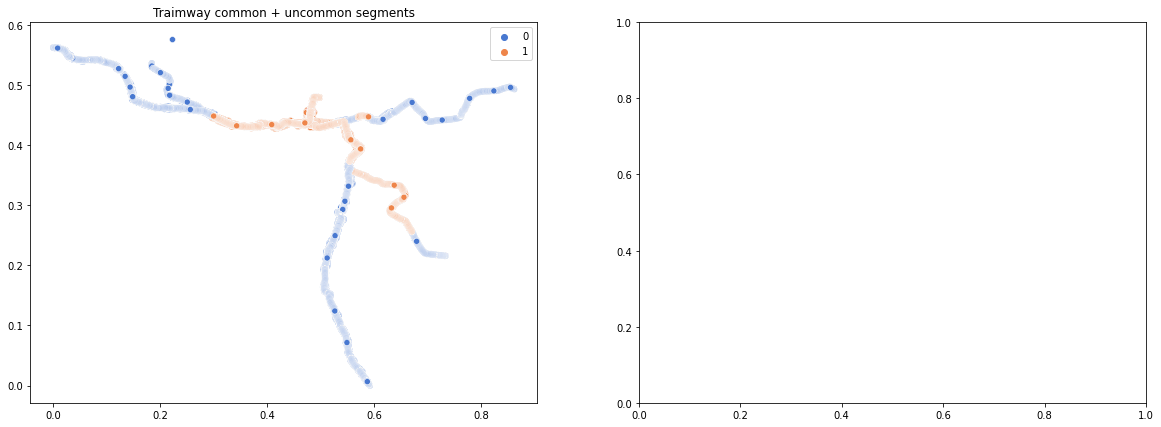

In [11]:
fig, axs = plt.subplots(1,2,figsize=(20,7))
sns.set_palette("muted")

train_ids = [1,6,8,12,14,16]   #train line ids
bus_ids = [4, 18, 22, 23, 28, 30, 50]  #Bus line ids

#------------------------------train---------------------------------
mask = pd.Series(target).isin(train_ids).values
x = data[mask][:,:,0].reshape(-1)
y = data[mask][:,:,1].reshape(-1)
axs[0].set_title('Traimway common + uncommon segments')
sns.scatterplot(x,y, ax=axs[0], hue=np.repeat(commonstops[mask],100).reshape((commonstops[mask].shape[0],100)).reshape(-1))


#--------------------------------Bus-----------------------------------
mask = pd.Series(target).isin(bus_ids).values
x = data[mask][:,:,0].reshape(-1)
y = data[mask][:,:,1].reshape(-1)
axs[1].set_title('Bus common + uncommon segments')
sns.scatterplot(x,y, ax=axs[1], hue=np.repeat(commonstops[mask],100).reshape((commonstops[mask].shape[0],100)).reshape(-1))

plt.show()

In [ ]:
extraction_path = '../dataPreprocessing/data/Fullpick_ETL/startified_sample/merged_sample/'

np.save(extraction_path+'features', data)
np.save(extraction_path+'labels', target)
np.save(extraction_path+'sequences', sequences)
np.save(extraction_path+'commonstops', commonstops)

In [ ]:
len(np.unique(target))

### Model training and validation

In [ ]:
data = np.load('../dataPreprocessing/data/Fullpick_ETL/startified_sample/merged_sample/features.npy', allow_pickle=True)
target = np.load('../dataPreprocessing/data/Fullpick_ETL/startified_sample/merged_sample/labels.npy')

In [ ]:
data.shape

In [ ]:
target.shape

In [ ]:
#model architecture keras API

def generate_model(hp=None):
    #default hyper parameters
    num_stacked_dense = 4
    droput_rate       = 0.2
    gru_units         = 128
    dense_units       = 128
    learning_rate     = 0.002
    num_stacked_gru   = 2
    leakyRelu_alpha   = 0
    num_stacked_convolution = 3
    num_convolution_kernels = 32
    
    if hp: #keras tuner hyper parameters
        num_stacked_dense = hp.Int('num_stacked_dense', min_value=1 , max_value=4)
        num_stacked_gru   = hp.Int('num_stacked_gru', min_value=0 , max_value=2)
        leakyRelu_alpha   = hp.Float('leakyRelu_alpha', min_value=0 , max_value=0.3) 
        droput_rate       = hp.Float('droput_rate', min_value=0.1 , max_value=0.5)
        learning_rate     = hp.Float('learning_rate', min_value=0.001, max_value=0.01)
        gru_units         = hp.Int('gru_units', min_value=64, max_value=256, step=32)
        dense_units       = hp.Int('dense_units', min_value=128, max_value=320, step=32)
        num_stacked_convolution = hp.Int('num_stacked_convolution', min_value=0 , max_value=3)
        num_convolution_kernels = hp.Int('num_convolution_kernels', min_value=16, max_value=64, step=16)

    #----------------------------------------------------Input-layers--------------------------------------------------
        
    inputs = layers.Input(shape = (200,6)) #input layer

    #----------------------------------------------Convolution-layers-Block--------------------------------------------

    #CNN + Maxpool block
    if num_stacked_convolution > 0 :
        x_conv = inputs[:,:,:4]
        for i in range(num_stacked_convolution):
            if i == 0 :
                x_conv = layers.Conv1D(num_convolution_kernels, 3, activation='relu',input_shape=(-1,200,6))(x_conv)
            else :
                x_conv = layers.Conv1D(num_convolution_kernels, 3, activation='relu')(x_conv)            
            x_conv = layers.Conv1D(num_convolution_kernels, 3, activation='relu' )(x_conv)
            x_conv = layers.MaxPooling1D(2)(x_conv)
        x_conv = layers.Flatten()(x_conv)
    
        #reduce output size of convoulution block outputs same as the gru outputs
        x_conv = layers.Dense(gru_units, activation='linear')(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = tf.nn.leaky_relu(x_conv, leakyRelu_alpha)
    
    #-----------------------------------------------------GRU-layers-Block--------------------------------------------

    if num_stacked_gru == 1 :
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, 200, 6), return_sequences=False )(inputs)
    else : 
        for i in range(num_stacked_gru):
            if i == 0 :
                x = layers.GRU(units=gru_units, activation='tanh', input_shape=(-1, 200, 6), return_sequences=True )(inputs)
            elif i == num_stacked_gru-1 :
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=False )(x)
            else :
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=True )(x)

    #-------------------------------------------nural-network-architecture-decision-block-----------------------------
    
    #feed inputs to a deep neural network
    #feed gru data to a deep neural network
    #feed a convolutional data to a deep neural network
    #feed a combination of gru + convolutional data to a deep neural network
    if num_stacked_convolution > 0 and num_stacked_gru > 0 :
        x_out = layers.concatenate([x_conv,x], axis=1)
    elif num_stacked_convolution > 0 and num_stacked_gru == 0 :
        x_out = x_conv
    elif num_stacked_convolution == 0 and num_stacked_gru > 0 :
        x_out = x
    else:
        x_out = inputs

    #-----------------------------------------------------Dense-layers-block------------------------------------------
        
    for i in range(num_stacked_dense):
        x_out = layers.Dense(dense_units, activation='linear')(x_out)
        x_out = layers.BatchNormalization()(x_out)
        x_out = tf.nn.leaky_relu(x_out, leakyRelu_alpha)
        x_out = layers.Dropout(droput_rate)(x_out)

    #--------------------------------------------------------output-layer---------------------------------------------

    #output layer
    out = layers.Dense(43, activation='softmax')(x_out)

    #--------------------------------------------------------model-compiler--------------------------------------------

    #build model
    model = Model(inputs, out)
    
    optimizer = Adam(lr=learning_rate)
    loss = SparseCategoricalCrossentropy(from_logits = True)
    metric = SparseCategoricalAccuracy()
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)

    return model

In [ ]:
model = generate_model()
model.summary()

In [ ]:
from sklearn.model_selection import KFold
import gc

class CVTuner(kt.engine.tuner.Tuner):
    
    #run trial override
    def run_trial(self, trial, X, y, epochs=1, verbose=True, callbacks=None, batch_size=512, k=5):
        
        val_losses = []        
        
        kf = KFold(n_splits=k)
        k_iter = 1
        for train_idx, val_idx in kf.split(X):            
            gc.collect()
            print('')
            print('------KFold--CrossValidation--iteration--N°{}------'.format(k_iter), end='\n\n')
            k_iter+=1
            #kfold cross-validation split
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            #tensorflow data pipeline
            train_set, validation_set = self.__tensorflow_dataPipeLine(X_train, y_train, X_val, y_val, batch_size)
            
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(train_set,
                      validation_data=validation_set,
                      epochs=epochs,
                      verbose = verbose,
                      callbacks=callbacks)

            val_losses.append(max(hist.history['val_sparse_categorical_accuracy'])) 
        val_losses = np.asarray(val_losses)
        self.oracle.update_trial(trial.trial_id, {'val_sparse_categorical_accuracy':np.mean(val_losses)})
        self.save_model(trial.trial_id, model)
        gc.collect()
        
    def __tensorflow_dataPipeLine(self, X_train, y_train, X_val, y_val, batch_size):

        dataset = Dataset.from_tensor_slices((X_train, y_train))
        dataset = dataset.batch(batch_size)
        dataset = dataset.shuffle(1000).repeat(2)
        train_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        dataset = Dataset.from_tensor_slices((X_val, y_val))
        dataset = dataset.batch(batch_size)
        dataset = dataset.shuffle(1000).repeat(2)
        validation_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        return train_set, validation_set

In [ ]:
tuner = CVTuner(
        hypermodel=generate_model,
        directory = './tuner',
        project_name = 'path_perdiction',
        overwrite = True,
        oracle=kt.oracles.BayesianOptimization(
        objective = kt.Objective("val_sparse_categorical_accuracy", direction="max"),
        max_trials=20))

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(features, target, epochs=30, k=5, batch_size=64,
             callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='val_sparse_categorical_accuracy')])

In [ ]:
f = os.listdir('tuner/path_prediction')[0]

In [ ]:
state_data = open('tuner/path_prediction/'+f+'/trial.json', mode='r')
state_data = json.loads(state_data.readline())

In [ ]:
state_data['metrics']

In [ ]:
import pandas as pd
import os
import json

trials = []
keys   = []
for filename in os.listdir('tuner/path_prediction') :
    try:
        state_data = open('tuner/path_prediction/'+filename+'/trial.json', mode='r')
        state_data = json.loads(state_data.readline())
        state_data['hyperparameters']['values'].update({'weighted f1score':state_data['metrics']['metrics']['val_weighted_f1score']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'accuracy':state_data['metrics']['metrics']['val_accuracy']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'weighted f1score common':state_data['metrics']['metrics']['val_weighted_f1score_common']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'weighted f1score uncommon':state_data['metrics']['metrics']['val_weighted_f1score_uncommon']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'macro f1score common':state_data['metrics']['metrics']['val_macro_f1score_common']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'macro f1score uncommon':state_data['metrics']['metrics']['val_macro_f1score_uncommon']['observations'][0]['value'][0]})
        state_data['hyperparameters']['values'].update({'stability':state_data['metrics']['metrics']['val_stability']['observations'][0]['value'][0]})

        trials.append(state_data['hyperparameters']['values'].values())
        keys = state_data['hyperparameters']['values'].keys()
        #print(filename)
    except : 
        pass
tunerTrials = pd.DataFrame(data=trials, columns=keys).dropna()
tunerTrials = tunerTrials.sort_values('weighted f1score', ascending=False).reset_index(drop=True)
tunerTrials

In [ ]:
tunerTrials[['weighted f1score','weighted f1score common','macro f1score common','weighted f1score uncommon','macro f1score uncommon','accuracy','stability']]

In [ ]:
tunerTrials.iloc[0]

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

In [ ]:
#export model
path_model.save_weights('./checkpoint/path_prediction.cpkt')

## Evaluation